#**Домашнее задание №5. Часть 2. Manifold. Homotopy.**<br>
**Выполнила: FIO.**


## Домашнее задание:

Написать арх-ру автоэнкодера и обучить ее так, чтобы получить низкую ошибку и качественный переход от одного реального изображения к другому на картинках ниже. 

In [19]:
 # Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import cycle

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm

In [21]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

EPOCHS = 40

cuda


In [22]:
# Train your autoencoder
def train(model, train_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss = []
    train_loss_epoch = []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            batch = X[0].to(device)  # [0] is needed due to X being a list of one element because no y in (X, y) 
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())
        
        train_loss_epoch.append(np.mean(train_loss))

        if epoch % 25 == 0:
            print(f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f}")

    return model, train_loss_epoch

In [23]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [24]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [25]:
train_data = train_data.data[:, None, :, :]
test_data = test_data.data[:, None, :, :]

X_train = torch.tensor(train_data, dtype=torch.float32)
X_test = torch.tensor(test_data, dtype=torch.float32)

dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

loaders = {
    'train' : torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=256, 
                                          shuffle=False, 
                                          num_workers=1),
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [26]:
train_data.shape

torch.Size([60000, 1, 28, 28])

In [27]:
iter(loaders['train']).next()[0].shape

torch.Size([256, 1, 28, 28])

In [28]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

def train(model, train_loader, val_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss, val_loss = [], []
    train_loss_epoch, val_loss_epoch = [], []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            batch = X[0].to(device)  # [0] is needed due to X being a list
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())

        model.eval()
        with torch.no_grad():
            for X in val_loader:
                batch = X[0].to(device)  # [0] is needed due to X being a list
                reconstruction, _ = model(batch)

                loss = criterion(reconstruction, batch)
                val_loss.append(loss.cpu().numpy())

        train_loss_epoch.append(np.mean(train_loss))
        val_loss_epoch.append(np.mean(val_loss))

        if epoch % 20 == 0:
            print(
                f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f};   "
                f"val loss: {val_loss_epoch[-1]:.6f}")

     #   os.makedirs(path, exist_ok=True)
        torch.save(model.state_dict(), path + '/checkpoint.pt')

    return model, train_loss_epoch, val_loss_epoch

In [29]:
def plot(train_loss_epoch, val_loss_epoch):
    plt.figure(figsize = (8, 6))
    plt.plot(train_loss_epoch, label='Train')
    plt.plot(val_loss_epoch, label='Valid')

    plt.title('Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [30]:
class CNNAutoencoder(nn.Module):

    def __init__(self, code_size=200):

        super().__init__()
        
        self.encoder = nn.Sequential(
                        
           nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(32),
           nn.ELU(),
           nn.MaxPool2d(kernel_size=2, stride=2),
           nn.Conv2d(in_channels=32, out_channels=code_size, kernel_size=3, stride=1, padding=1),

       )
        self.decoder = nn.Sequential(

           nn.ConvTranspose2d(in_channels=code_size, out_channels=32, kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(32),
           nn.ELU(),
           nn.Upsample(scale_factor=2, mode='bilinear'),
           nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),

        )
        
       
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code


In [31]:
criterion = torch.nn.MSELoss()

conv_autoencoder1 = CNNAutoencoder()
conv_autoencoder1.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(conv_autoencoder1.parameters(), lr=7e-4)
conv_model, train_loss, val_loss = train(conv_autoencoder1, 
                               loaders['train'], loaders['test'],
                               device=DEVICE, epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

After 0 epochs, training loss: 4124.755371;   val loss: 2480.656494
After 20 epochs, training loss: 540.988037;   val loss: 418.600433
After 40 epochs, training loss: 352.022980;   val loss: 289.237793
After 60 epochs, training loss: 279.823029;   val loss: 237.390991
After 80 epochs, training loss: 240.646591;   val loss: 208.604980
After 100 epochs, training loss: 215.675644;   val loss: 189.870895
After 120 epochs, training loss: 198.167679;   val loss: 176.596039
After 140 epochs, training loss: 185.123962;   val loss: 166.543625
After 160 epochs, training loss: 174.969498;   val loss: 158.673553
After 180 epochs, training loss: 166.810867;   val loss: 152.302338


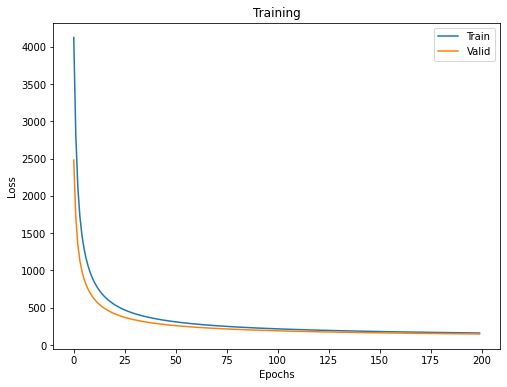

In [32]:
plot(train_loss, val_loss)

In [33]:
def plot_digits(args):
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(40, 60))
    for j in range(n):
        for i in range(len(args)):
            plt.subplot(n, len(args), i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()

    plt.show()

# Гомотопия по прямой между объектами или между кодами
def plot_homotopy(frm, to, n=10, decode=False, model=conv_model, device=DEVICE):
    z = []
    for i, weight in enumerate(np.linspace(0., 1., n)):
        z.append(frm * (1-weight) + to * weight)
    if decode:
        with torch.no_grad():
            print(len(z[0]))
            z = [elem[None, :].to(device) for elem in z]
            z = torch.cat(z)
            reconstruction = model.decoder(z)
            reconstruction = reconstruction.cpu()
        plot_digits(reconstruction)
    else:
        plot_digits(z)

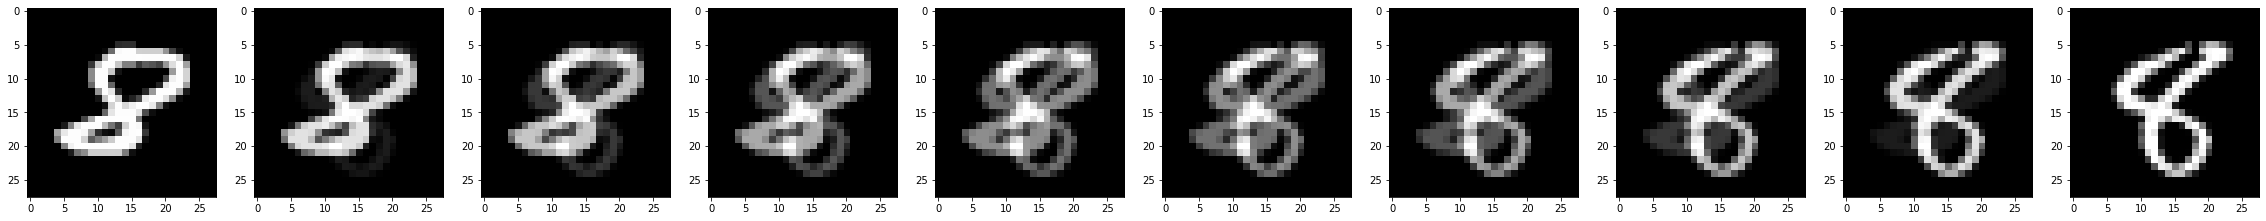

In [34]:
# Гомотопия между первыми двумя восьмерками

# 61 и 84 выбраны не случайно, под такими индексами в тестовых данных хранятся восьмерки

frm = dataset_test[61][0]
to = dataset_test[84][0]
plot_homotopy(frm, to)

Если наше латентное пространтсво корректное, мы нашли правильно параметаризованное латентное пространство, 
то небольшие сдвиги в этом пространстве должны давать разумные результаты: 

**Можно сказать то же самое, но завернуть это более витиевато:** Если же двигаться по кривой между кодами (и если многообразие кодов хорошо параметризовано), то декодер переведет эту кривую из пространства кодов, в кривую, не покидающую определяющее многообразие в пространстве объектов. То есть промежуточные объекты на кривой будут принадлежать генеральной совокупности.

In [35]:
conv_model.encoder(frm[None, :, :, :].to(DEVICE)).shape

torch.Size([1, 200, 14, 14])

200


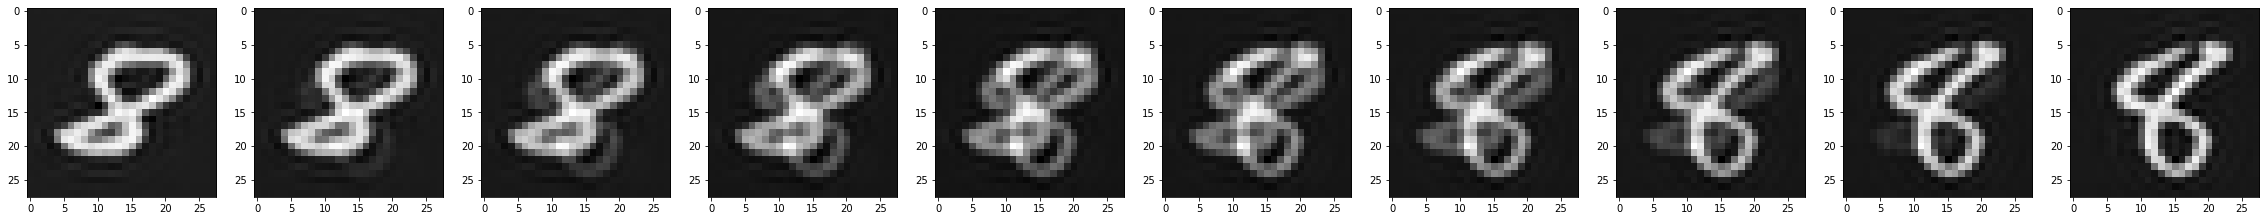

In [36]:
frm = dataset_test[61][0]
to = dataset_test[84][0]

with torch.no_grad():
    frm_enc = conv_model.encoder(frm[None, :, :, :].to(DEVICE))
    to_enc = conv_model.encoder(to[None, :, :, :].to(DEVICE))
    codes = torch.cat([frm_enc, to_enc])

plot_homotopy(codes[0], codes[1], n=10, decode=True)
# plot_homotopy(frm, to, n=10, decode=True)